Opět se vracím k řešení nějaké hry, a sice Sudoku. Nejdříve zkusím řešení s využitím síly Depth-first search (DFS).

V případě Sudoku se jedná o hru s čísly ve dvourozměrné matici __9x9__ kostek s čísly v rozsahnu __<1..9>__.


# Jak budu reprezentovat aktuální stav hry

Mohl bych pracovat přímo s dvourozměrnou matící, třeba s využitím _numpy_, nicméně v prvním kole si zkusím vystačit s normálními řetězci.

Matici budu reprezentovat jako jeden řetězec poskládaný z jednotlivých řádků za sebou. V případě, kdy je číslo na dané pozici neznámé, budu jej reprezentovat nulou.

Takhle nějak by mohl vypadav vzorek Sudoku před začátkem řešení:

```003870500000002180049651030006000053050000072072305010200068000000020000030510000```


# Jak budu řešení testovat
Asi trochu předbíhám, ale je to podstatná otázka vždy, když začínám něco psát. Jak si to své dílko vlastně vyzkouším?

Tohle jsem tedy používal:
* mám čtyři vyřešené Sudoku jako výchozí bod
* pro každý běh testování si vyberu obtížnost, což je počet neznámých políček v sudoku (rozmezí od 1 do 80)
* v každém vzorku sudoku náhodně vybírám pozici a nahrazuji jí 0, dokud není celkový počet nul roven obtížnosti
* nakonec na všechny vzorky pošlu algoritmus řešení sudoku a měřím, jak dlouho trvá vyřešení
* výsledkem je pak průměr doby řešení pro každou obtížnost

Vlastní testovací nástroj je vidět tady:

In [1]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

samples = [
    "123874569567932184849651237916247853358196472472385916291768345685423791734519628",
    "531769248427831956869425173182546397645397821973182465354278619798614532216953784",
    "816294357543718269792635148438576912175942836629381475964127583287453691351869724",
    "812753649943682175675491283154237896369845721287169534521974368438526917796318452",
]

def test_algorithm(f, X):
    
    def prepare_sample(s, difficulty):
        while s.count('0') < difficulty:
            i = random.randrange(len(s))
            s = s[:i] + '0' + s[i+1:]
        return s

    results = []
    for difficulty in X:
        random.seed(0)
        spent_time = 0
        for s in samples:
            sample = prepare_sample(s, difficulty)
            res = f(sample)
            if not res:
                print(f"FAILED: {difficulty=} {sample=}")
                return
            spent_time += res[1]
        results.append(spent_time / len(samples))
    return results

def timed(func):
    """
    Function execution time measurement annotation.
    
    :param func:   pursued function
    :return:       2-elements tuple (<function result>, <execution time in milliseconds>)
    """
    def func_wrapper(*args, **kwargs):
        import time
        start_time = time.time_ns()
        result = func(*args, **kwargs)
        end_time = time.time_ns()
        return result, (end_time - start_time) / 10**6
    return func_wrapper

# První řešení s využitím DFS
Postup je v podstatě jednoduchý:
1. Najdu si první pozici s neznámou hodnotou (ve vzorku hodnota 0)
2. Pro danou pozici si zjistím množinu všech možných čísel, která tam mohou být
    * jako základ je množina čísel 1..9
    * od ní odečtu množinu čísel ve stejném řádku
    * od toho odečtu množinu čísel ve stejném sloupci
    * od toho odečtu množitu čísel ve stejném čtverci
3. Pro každé číslo z možných pro danou pozici:
    * doplním číslo na danou pozici
    * zkusím, zda existuje řešení s takto doplněnou pozicí (volám rekurzivně)
4. Vše končí, pokud již nemám volnou pozici. 
5. Vysledkem je pak řešení, které vyhovuje pravidlům pro Sudoku nebo None v případě, že řešení není.

Takhle vypadá funkce pro tohle řešení:


In [2]:
@timed
def solution_1(sample):

    def rowFor(sample, i):
        i = i // 9 * 9
        return sample[i:i+9]

    def columnFor(sample, i):
        return sample[i%9:len(sample):9]

    def squareFor(sample, i):
        x0 = (i % 9) // 3 * 3
        y0 = (i // 9) // 3 * 3
        return ''.join([sample[(y0 + j) * 9 + x0:(y0 + j) * 9 + x0 + 3] for j in range(3)])

    allSet = set((chr(i) for i in range(ord('1'), ord('9')+1)))

    def solve(sample):
            nextIndex = sample.find('0')
            if nextIndex >= 0:
                possible = allSet - set(rowFor(sample, nextIndex)) - set(columnFor(sample, nextIndex)) - set(squareFor(sample, nextIndex))
                for v in possible:
                    newSample = sample[:nextIndex] + v + sample[nextIndex + 1:]
                    res = solve(newSample)
                    if res:
                        return res
                else:
                    return None
            else:
                return sample

    return ''.join(solve(sample))


## Výsledky testování prvního řešení
A takto jsem to první řešení testoval:

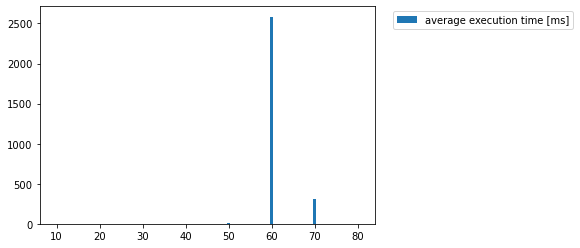

In [3]:
X = list(range(10, 81, 10))
res = test_algorithm(solution_1, X)

plt.bar(X, res, label="average execution time [ms]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Z grafu je zřejmé, že nejobtížnější nalezení vyhovujícího řešení je kolem obtížnosti někde mezi 60 a 70 (neznámých hodnot). 

Nejdříve mne to překvapilo, protože bych čekal, že nejobtížnější to bude pro skoro prázdné Sudoku. Nicméně to dává smysl. U hodně prázdných Sudoku je těch možných řešení hodně, proto rychleji dojdu na nějaké vyhovující.

__Při opakovaném experimentování jsem ale narazil na problémy, že některá zadání trvala extrémně dlouho. Nevím, v čem je problém, třeba se tím ještě někdy budu bavit__.

# Druhé řešení s DFS
Zkusil jsem ještě to první řešení trochu vylepšit. Kde by to mohlo jít?

Pokud se podívám na první řešení, tak najdu první neznámou pozici, zkusím na ní doplnit nějakou hodnotu a pak se zanořím. V tomto případě vůbec neřeším, jestli by nebylo lepší začít nějakou jinou pozicí. Mohla by se ve vzorku najít jiná pozice, na niž je možné doplnit jenom jednu hodnotu. Pak bych neměl strom řešení tak široký.

Takže v čem spočívá druhé řešení?

Nejdříve projdu všechny neznáme pozice a spočítám pro ně množiny všech čísel, které na danou pozici je možné doplnit. Seznam seřadím podle velikosti těchto množin vzestupně. Nejdříve tedy příjdou na řadu pozice, které mají nejmenší množiny možných hodnot.

Takhle vypadá funkce pro druhé řešení:

In [4]:
@timed
def solution_2(sample):

    def rowFor(sample, i):
        i = i // 9 * 9
        return sample[i:i+9]

    def columnFor(sample, i):
        return sample[i%9:len(sample):9]

    def squareFor(sample, i):
        x0 = (i % 9) // 3 * 3
        y0 = (i // 9) // 3 * 3
        return ''.join([sample[(y0 + j) * 9 + x0:(y0 + j) * 9 + x0 + 3] for j in range(3)])

    allSet = set((chr(i) for i in range(ord('1'), ord('9')+1)))

    def potentials(sample, i):
        return allSet - set(rowFor(sample, i)) - set(columnFor(sample, i)) - set(squareFor(sample, i))

    def solve(sample, holes):
        if holes:
            i, pos = holes[0]
            for v in pos:
                newSample = sample[:i] + v + sample[i+1:]
                res = solve(newSample, holes[1:])
                if res:
                    return res
            else:
                return None
        else:
            return sample

    holes = sorted([(i, potentials(sample, i)) for i, v in enumerate(sample) if v == '0'], key=lambda x: len(x[1]))
    return solve(sample, holes)

## Výsledky testování druhého řešení
A takto jsem to druhé řešení testoval:

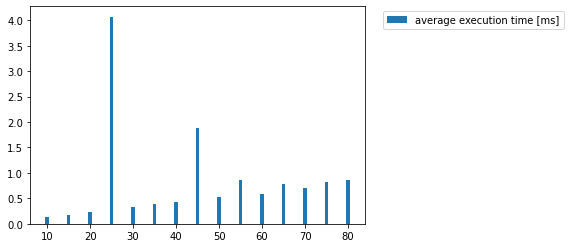

In [5]:
X = list(range(10, 81, 5))
res = test_algorithm(solution_2, X)

plt.bar(X, res, label="average execution time [ms]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

Dle hodnot průměrného času je vidět, že to druhé řešení je lepší než to první. 

Čas řešení se přesunul směrem k větší obtížnosti. To je dáno tím, že u těchto složitostí jsou na většině pozic možná skoro všechna čísla. Proto jsem si v těchto případech moc nepomohl tím seřazením.

Zkusil jsem tomu ještě pomoci tím, že přepočítám množinu možných hodnot pro pozici v každé iteraci. Ale vůbec jsem tomu nepomohl, výsledky byly horší. Je to asi dáno tím, že to přepočítávání také něco stojí.

A to je vše.